In [58]:
using JLD
using PyPlot
using Statistics, StatsBase #mean and std

In [59]:
nombrecm="/home/karel/BRWFiles/estriado/Cacho_6_estriado_slice1_1004A-CM.jld"
archivo=load(nombrecm)
DatosCMP=archivo["CMP"]
DatosCMN=archivo["CMN"];
evocada=false
nmax=length(DatosCMP) #cuantos cuadros hay

89275

In [60]:
DatosCMP[1337]

0×3 Array{Int64,2}

In [61]:
DatosCMP[1341]

0×3 Array{Int64,2}

In [62]:
function leeunmegaarrayarchivos(NomineGeneralis::AbstractString, desde=35, hasta=501)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
            readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
    end


function leunjlddeCM(datos, desde=1, hasta=300)
    LeMegaArray=Array[]
    for t=desde:hasta
      #  println("$NomineGeneralis-$t.dat")
        CMx=try 
        readdlm("$NomineGeneralis-$t.dat")
        catch
            []
        end
        push!(LeMegaArray, CMx)
    end
    return LeMegaArray
end



leunjlddeCM (generic function with 3 methods)

Para Evocados, hay un par de variables temporales para considerar:
- retrazo: el tiempo en cuadros que hubo desde el comienzo del registro hasta el estimulo
- latencia: el tiempo en cuadros que hubo desde el estimulo hasta que paso algo interesante


In [63]:
#freq=7.022 # la frecuencia de muestreo en kHz de los experimentos viejos
freq=17.85550205219098 # la freq de los nuevos, en kHz
 
if evocada
    retms=5.0 #retrazo en milisec
    latms=4.0 #latencia en milisec
    retrazo=round(Int, retms * freq)
    lat=round(Int, latms * freq)
    desde=retrazo+lat
    hasta=300
else
    retms=0
    latms=0
    retrazo=0
    lat=0
    desde=1
    hasta=nmax
end

89275

In [64]:
function dist2D(x,y)
    result=sqrt((x[1]-y[1])^2+(x[2]-y[2])^2)
    return result
end

function difgordis(x,y)
    result=abs(x-y)/max(abs(x),abs(y))
    return result
end

difgordis (generic function with 1 method)

In [65]:
difgordis(0.21,0.29)

0.27586206896551724

In [66]:
function encuentraTrayectorias(Datos, mincadena=20, mingordo=2.0, desde=1,hasta=20)

toleradist=16.0*sqrt(2)
#toldifgordis=0.33
tau=1
t=1
j=1

Catenario=Dict{Integer, Array{Any}}()
Cadena=[0 0 0 0]
tnum=1
CopiaMegaArray=deepcopy(Datos);
NumFrames=length(Datos)
FakeNumFrames=NumFrames



while t <= FakeNumFrames-1 
    
    tau=t
    
    @label arrrrh
 
        if(CopiaMegaArray[tau]==[])
            
            jmax,nada=0,0
        else
          
     jmax,nada= size(CopiaMegaArray[tau])
        end
    
        
    while j <=jmax && tau<FakeNumFrames
            
            if abs(CopiaMegaArray[tau][j,3]) > mingordo
                
            Eslabon=[transpose(CopiaMegaArray[tau][j,:]) tau]
            Cadena=vcat(Cadena, Eslabon)
         #   println("Papa t: ", t, "  tau: ", tau, " y  j: ",j )
            mindist=2
            kasterisco=1
                
                if CopiaMegaArray[tau+1]==[]
                    kmax,nada=0,0
                else
                kmax, nada= size(CopiaMegaArray[tau+1])
                end
                huboalgo=false
          
        #    kmax=5
            
            for k=1:kmax
                
                EslabonTentativo=CopiaMegaArray[tau+1][k,:]
            #    println(EslabonTentativo)
                    if abs(EslabonTentativo[3])>mingordo
                    dist=dist2D(Eslabon,EslabonTentativo)                  
                    if dist<mindist
                        mindist=dist
                        kasterisco=k
                        
                       # println(kasterisco, "=k*", k, "=k")
                        huboalgo=true
                    end
                end
            
            end    
            
            if huboalgo && mindist<toleradist
                #quitamos el anterior
                CopiaMegaArray[tau][j,3]=0.0000 
               # println(mindist," ", t, " ", tau+1 ," ", kasterisco )
                
                if tau+1<FakeNumFrames
                    tau+=1
                    j=kasterisco
      #              println("Pepe t: ", t, "  tau: ", tau, " y  j: ",j )
                    @goto arrrrh
                
                else
                    
                    Eslabon=[transpose(CopiaMegaArray[tau+1][kasterisco,:]) tau+1]
                    Cadena=vcat(Cadena, Eslabon)
      #              println("Pipi t: ", t, "  t: ", t, " y  j: ",j )
                    j+=1
                    tau=t
                    
                    if size(Cadena)[1]>mincadena
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                    end
                    
                    Cadena=[0 0 0 0]
                    @goto arrrrh
                end
                                
            else
                
                if size(Cadena)[1]>mincadena
                    # veamos si funciona  mejor como dict 
                        #push!(Catenario, Cadena[2:end,:])
                        Catenario[tnum]=Cadena[2:end,:]
                        tnum+=1
                end
                Cadena=[0 0 0 0]
                j+=1
                tau=t
                @goto arrrrh
            end
                       
        end #cierra sobre el if de  la masa 
                
        j+=1                    
        tau=t
    
    end
    @label urrr
      
    j=1
    t+=1
    tau=t
    Cadena=[0 0 0 0]
        end 
    
    return Catenario
end

encuentraTrayectorias (generic function with 5 methods)

In [67]:
(desde, hasta)


(1, 89275)

In [68]:
pesomin=5
longmin=3

3

In [69]:
#Recuerda el segundo argumento es la longitud mínima de la cadena
@time CatenarioPositivo=encuentraTrayectorias(DatosCMP,longmin,pesomin,desde,hasta);


  3.218217 seconds (3.68 M allocations: 8.875 GiB, 30.70% gc time)


In [70]:
CatenarioNegativo=encuentraTrayectorias(DatosCMN,longmin,pesomin,desde,hasta);

In [55]:
nombreout=nombrecm[1:end-6]*"Tray-todas.jld"
nota="longitud minima fue $longmin, peso minimo fue $pesomin "
save(nombreout, "CatenarioNegativo", CatenarioNegativo, "CatenarioPositivo", CatenarioPositivo, "nota", nota)

In [71]:
length(CatenarioPositivo), length(CatenarioNegativo)

(346, 1102)

In [72]:
CatenarioPositivo

Dict{Integer,Array{Any,N} where N} with 346 entries:
  288 => Any[30.505 33.5555 57.8864 78645.0; 30.5005 33.5365 70.255 78646.0; … …
  306 => Any[8.43692 13.4448 67.5754 81067.0; 8.43081 13.4541 68.5466 81068.0; …
  11  => Any[6.96499 40.4727 99.5611 2610.0; 6.97541 40.4693 105.188 2611.0; 7.…
  134 => Any[8.40725 13.4966 66.5606 37858.0; 8.41911 13.5131 67.8592 37859.0; …
  158 => Any[39.9329 5.46427 106.354 42940.0; 39.838 5.57705 114.728 42941.0; ……
  160 => Any[4.71706 39.5008 92.6526 42943.0; 4.69223 39.5011 94.3215 42944.0; …
  215 => Any[21.4569 46.3397 55.6876 57873.0; 21.734 46.287 57.1991 57874.0; 22…
  29  => Any[41.3944 6.84857 115.129 7230.0; 41.4059 6.90863 113.858 7231.0; … …
  131 => Any[13.3501 57.4735 80.3433 37098.0; 13.3978 57.5254 75.5834 37099.0; …
  249 => Any[19.4899 31.4102 65.314 69325.0; 19.4907 31.4115 65.9285 69326.0; 1…
  207 => Any[21.0995 45.7747 95.8722 57060.0; 20.9312 45.868 141.528 57061.0; ……
  300 => Any[12.4337 13.5283 66.5694 78798.0; 12.4873 13

In [73]:
nombreout

"/home/karel/BRWFiles/estriado/Cacho_6_estriado_slice1_1004A-Tray-todas.jld"

In [74]:
values(CatenarioNegativo)

Base.ValueIterator for a Dict{Integer,Array{Any,N} where N} with 1102 entries. Values:
  Any[21.4884 23.4329 -76.7954 27085.0; 21.4673 23.4593 -88.134 27086.0; … ; 21…
  Any[21.7304 22.5432 -113.998 88250.0; 21.7534 22.5945 -148.068 88251.0; … ; 2…
  Any[24.1229 26.6339 -88.3571 1244.0; 23.9245 26.5862 -79.8585 1245.0; 23.8928…
  Any[26.5414 44.5342 -65.6183 4872.0; 26.5756 44.4911 -66.2758 4873.0; 26.5817…
  Any[28.3128 19.5211 -87.4428 76712.0; 28.3611 19.4788 -88.8486 76713.0; … ; 2…
  Any[35.5897 62.4434 -68.126 13306.0; 35.5635 62.4533 -70.9124 13307.0; 35.502…
  Any[26.3283 40.5592 -88.3579 76153.0; 26.3819 40.588 -101.421 76154.0; … ; 26…
  Any[17.5797 39.4914 -72.7008 24490.0; 17.5606 39.4814 -76.3987 24491.0; 17.54…
  Any[26.3945 40.5451 -75.3345 28154.0; 26.4263 40.5206 -82.4235 28155.0; … ; 2…
  Any[23.4667 18.3784 -96.6787 75030.0; 23.4568 18.4343 -101.28 75031.0; … ; 23…
  Any[31.4484 16.5228 -64.2599 80225.0; 31.4331 16.5378 -66.6368 80226.0; 31.41…
  Any[28.5168 18.4383 

In [75]:
save(nombreout, "CatenarioPositivo", CatenarioPositivo, "CatenarioNegativo", CatenarioNegativo, "notatray", nota)

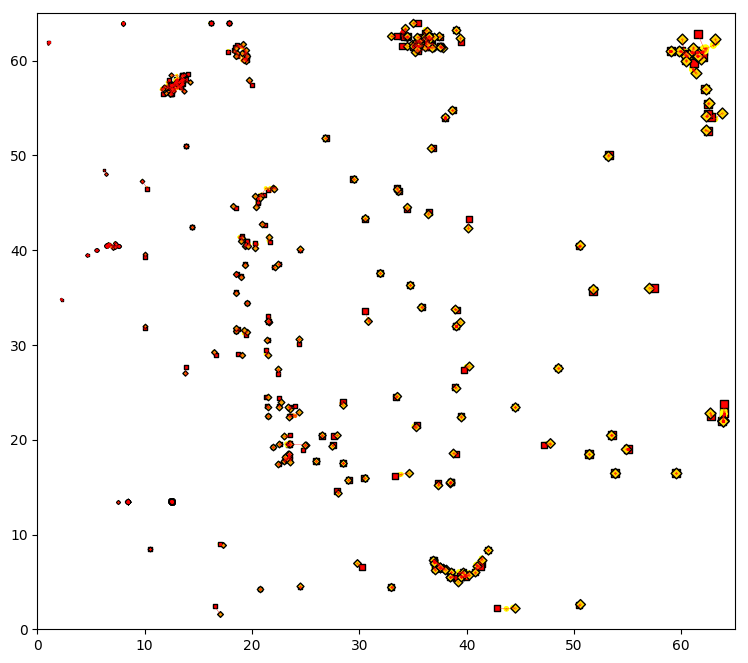

In [76]:
#PyPlot.ion()
figure(figsize=(9,8))
#axis("equal")
xlim(0.0,65.0)
ylim(0.0,65.0)
tolerancia=0
minlong=0
maxlong=20000
#colores=Union{}

for p in values(CatenarioPositivo)
    gordura=abs(p[:3])
    longus,gordus=size(p)
    if (mean(gordura)>tolerancia) && (longus>minlong) && longus < maxlong
        #Si son chiquitos no nos interesan.
        xxpos=p[:,1]
        yypos=p[:,2]    
        tiempos=p[:,4]/7022    
        plot(xxpos, yypos, marker="o", markersize=0.25, color="r", lw=0.25, zorder=15)
        colores=scatter(xxpos,yypos, s=gordura*0.4, edgecolors="none", 
        c=tiempos, cmap="autumn", vmin=0.0, vmax=0.72 )
        principios=scatter(xxpos[1],yypos[1], s=gordura*0.5,
        edgecolors="black", 
        color="r", marker="s", label="Inicio" ,
        zorder=1)
        finales=scatter(xxpos[end],yypos[end], s=gordura*0.5, edgecolors="black", 
        color="gold", marker="D", label="Final", zorder=2 )
        # annotate(round(tiempos[1],4),  (xxpos[1], yypos[1]), fontsize=7, color="black")
        # annotate(round(tiempos[end],4), (xxpos[end], yypos[end]), fontsize=7, color="green")

    end
end

#savefig("ejemploaltaspositivas-01.svg",dpi=92)

In [31]:
JLD.save

save (generic function with 8 methods)